# Prerequisites

In [1]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.applications.inception_v3 as inception_v3
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.applications.resnet50 as resnet50
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Flatten
from keras.applications import InceptionV3
from keras.models import load_model
from tensorflow.keras import utils
import tensorflow as tf

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from apps.dataset import Dataset
from PIL import Image
import numpy as np
import pandas as pd
import random
import json



# Data load and augumentation

In [2]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

img_gen_train = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(rescale=1./255,
                             preprocessing_function=preprocess_input)

In [3]:
train_dataset = img_gen_train.flow_from_directory('data/variant/train',
                                                  target_size=(299,299),
                                                  shuffle = True)

val_dataset = img_gen.flow_from_directory('data/variant/val',
                                          target_size=(299,299),
                                          shuffle = True)

test_dataset = img_gen.flow_from_directory('data/variant/test',
                                           target_size=(299,299),
                                           shuffle = False)



Found 3315 images belonging to 100 classes.
Found 3306 images belonging to 100 classes.
Found 3307 images belonging to 100 classes.


In [4]:
with open('class_indices.json', 'w') as fp:
    json.dump(test_dataset.class_indices,fp)

# Model Creation

As base model InveptionV3 architecture (without top layer) is used. Top layer consists of one Flatten layer, Dense layer, Dropout and Dense layer.

In [4]:
model_base = InceptionV3(weights = 'imagenet', include_top=False, input_shape = (299, 299, 3))

for layer in model_base.layers:
    layer.trainable = True
    
n_classes = len(set(train_dataset.classes))

top_model = Sequential()
top_model.add(Flatten(input_shape = model_base.output_shape[1:]))
top_model.add(Dense(200, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_classes, activation='softmax'))

model = Sequential()
model.add(model_base)
model.add(top_model)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
sequential (Sequential)      (None, 100)               26234700  
Total params: 48,037,484
Trainable params: 48,003,052
Non-trainable params: 34,432
_________________________________________________________________


Model initialization. Early stopping and checkpoint saving is used. SGD optimizer used.

In [5]:
history_base = History()

model.compile(loss='categorical_crossentropy',
             optimizer = 'sgd',
             metrics=['accuracy'])

early_stopping = EarlyStopping(patience=20,monitor="val_loss")
checkpoint_path = 'checkpoint_full/' + 'model_base' + '-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)

model.fit(train_dataset, epochs=1000, batch_size=32,
                    validation_data=val_dataset, callbacks =[early_stopping, checkpoint, history_base])


Epoch 1/1000
104/104 [==============================] - 117s 988ms/step - loss: 4.9110 - accuracy: 0.0046 - val_loss: 4.6056 - val_accuracy: 0.0085

Epoch 00001: val_loss improved from inf to 4.60560, saving model to checkpoint_full/model_base-ep001-loss4.687-val_loss4.606.h5
Epoch 2/1000
104/104 [==============================] - 89s 848ms/step - loss: 4.6067 - accuracy: 0.0067 - val_loss: 4.6051 - val_accuracy: 0.0124

Epoch 00002: val_loss improved from 4.60560 to 4.60508, saving model to checkpoint_full/model_base-ep002-loss4.605-val_loss4.605.h5
Epoch 3/1000
104/104 [==============================] - 100s 967ms/step - loss: 4.6025 - accuracy: 0.0097 - val_loss: 4.5929 - val_accuracy: 0.0181

Epoch 00003: val_loss improved from 4.60508 to 4.59293, saving model to checkpoint_full/model_base-ep003-loss4.598-val_loss4.593.h5
Epoch 4/1000
104/104 [==============================] - 91s 871ms/step - loss: 4.5691 - accuracy: 0.0152 - val_loss: 4.5221 - val_accuracy: 0.0191

Epoch 00004: v


Epoch 00030: val_loss improved from 1.88867 to 1.83481, saving model to checkpoint_full/model_base-ep030-loss2.232-val_loss1.835.h5
Epoch 31/1000
104/104 [==============================] - 91s 873ms/step - loss: 2.1186 - accuracy: 0.3904 - val_loss: 1.7243 - val_accuracy: 0.4900

Epoch 00031: val_loss improved from 1.83481 to 1.72430, saving model to checkpoint_full/model_base-ep031-loss2.101-val_loss1.724.h5
Epoch 32/1000
104/104 [==============================] - 88s 842ms/step - loss: 2.0499 - accuracy: 0.3962 - val_loss: 1.6593 - val_accuracy: 0.5006

Epoch 00032: val_loss improved from 1.72430 to 1.65932, saving model to checkpoint_full/model_base-ep032-loss2.007-val_loss1.659.h5
Epoch 33/1000
104/104 [==============================] - 105s 1s/step - loss: 1.8718 - accuracy: 0.4472 - val_loss: 1.5717 - val_accuracy: 0.5251

Epoch 00033: val_loss improved from 1.65932 to 1.57165, saving model to checkpoint_full/model_base-ep033-loss1.862-val_loss1.572.h5
Epoch 34/1000
104/104 [===

Model and it's weights are saved to use for future images evaluation.

In [103]:
model.save('final_models/model_001.h5')

Learning Curves (comment below curves)

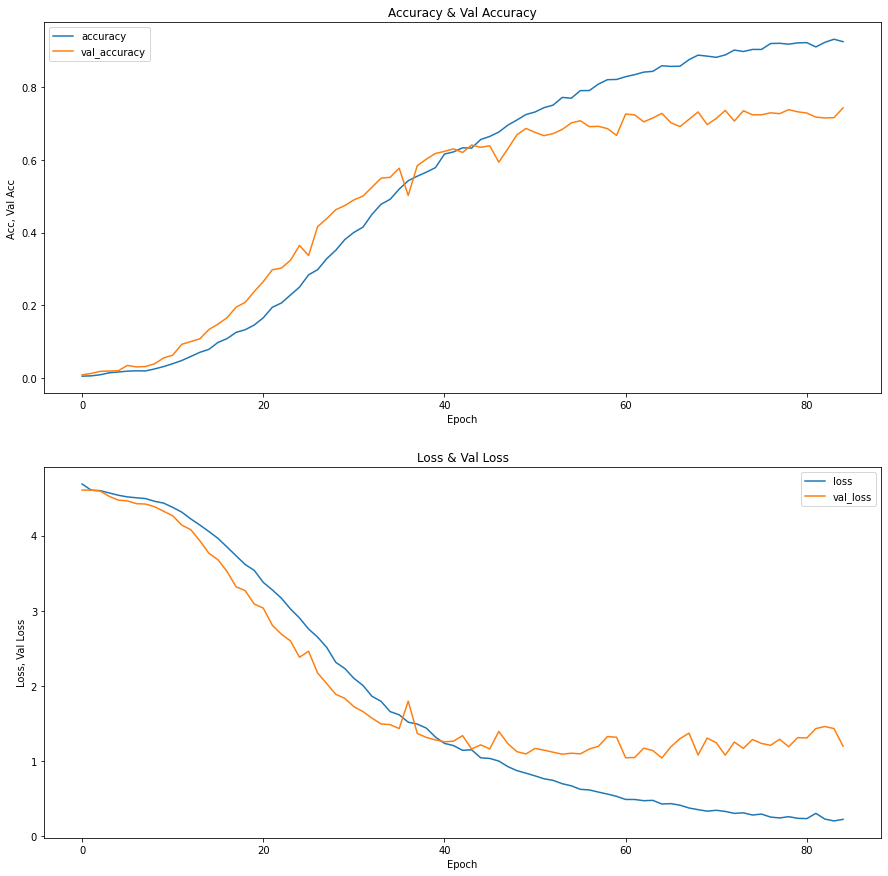

In [6]:
fig, axs = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
axs[0].plot(history_base.history['accuracy'], label = "accuracy")
axs[0].plot(history_base.history['val_accuracy'], label = "val_accuracy")
axs[0].legend()
axs[0].set_title('Accuracy & Val Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Acc, Val Acc')


axs[1].plot(history_base.history['loss'], label = "loss")
axs[1].plot(history_base.history['val_loss'], label = "val_loss")
axs[1].legend()
axs[1].set_title('Loss & Val Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss, Val Loss')


plt.show()

Model gives higher validation accuracy than training accuracy in the first phase of learning (up to ~ 40 epochs). It may indicate that model is overfitted, but after 40 epochs situation changes and training accuracy is higher than validation accuracy. That situation may be an indicator of the fact that validation dataset is easier than training one.

## Post Processing

Load model after opening new jupyter session

In [5]:
model = load_model('final_models/model_001.h5')

Evaluation of model on test data. General accuracy ~77%

In [6]:
evalu_1 = model.evaluate(test_dataset)

104/104 [==============================] - 18s 136ms/step - loss: 1.0865 - accuracy: 0.7696


### Categorical Accuracy 

In [7]:
preds = model.predict(test_dataset)

In [8]:
def get_key_by_value(d, value):
    for k, v in d.items():
        if v == value:
            return k

In [10]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

preds_df_1 = pd.DataFrame({
    'File' : test_dataset.filenames,
    'Actual': [get_key_by_value(test_dataset.class_indices, line) for line in test_dataset.labels],
    'Prediction': [get_key_by_value(test_dataset.class_indices, np.argmax(line, axis=None, out=None)) for line in preds],
})

preds_df_1['Comparison Column'] = np.where(preds_df_1["Actual"] == preds_df_1["Prediction"], 1, 0)

names = {'Actual': 'Aircraft Variant',
        'Comparison Column' : 'Accuracy'}

categorical_accuracy_1 = preds_df_1.groupby('Actual')['Comparison Column'].mean()
categorical_accuracy_1 = categorical_accuracy_1.reset_index().rename(columns = names).set_index('Aircraft Variant').sort_values(by = 'Accuracy', ascending = False)
categorical_accuracy_1

Accuracy
Aircraft Variant             
F-16AB               1.000000
E-190                0.970588
Eurofighter_Typhoon  0.970588
SR-20                0.970588
Saab_2000            0.969697
FA-18                0.969697
DHC-8-100            0.969697
Tornado              0.969697
Beechcraft_1900      0.969697
DH-82                0.968750
Metroliner           0.941176
PA-28                0.939394
Model_B200           0.939394
CRJ-200              0.939394
Cessna_525           0.939394
Tu-134               0.939394
An-12                0.939394
DR-400               0.911765
DC-9-30              0.911765
Falcon_2000          0.911765
Il-76                0.911765
ATR-42               0.909091
Yak-42               0.909091
Fokker_70            0.909091
Global_Express       0.909091
Gulfstream_V         0.909091
Tu-154               0.882353
Dornier_328          0.878788
Challenger_600       0.878788
Hawk_T1              0.878788
C-130                0.878788
BAE-125              0.878788
737-200              0.875000
A340-600             0.870968
Cessna_172           0.852941
Boeing_717           0.852941
Cessna_560           0.852941
ATR-72               0.852941
CRJ-900              0.848485
Saab_340             0.848485
ERJ_145              0.848485
DHC-6                0.823529
A318                 0.823529
Gulfstream_IV        0.823529
Spitfire             0.823529
MD-11                0.818182
DHC-1                0.818182
Cessna_208           0.818182
757-300              0.818182
727-200              0.818182
Embraer_Legacy_600   0.818182
Fokker_50            0.818182
Falcon_900           0.818182
Fokker_100           0.812500
767-200              0.812500
A320                 0.806452
A340-200             0.794118
767-400              0.757576
A321                 0.757576
L-1011               0.757576
737-700              0.757576
DC-8                 0.750000
EMB-120              0.727273
737-900              0.727273
BAE_146-200          0.727273
707-320              0.727273
CRJ-700              0.727273
A380                 0.696970
DC-6                 0.696970
A340-500             0.689655
747-100              0.687500
737-800              0.676471
777-300              0.676471
DC-3                 0.666667
C-47                 0.666667
737-600              0.666667
DC-10                0.666667
A319                 0.666667
777-200              0.656250
ERJ_135              0.647059
747-300              0.636364
E-170                0.625000
737-500              0.617647
BAE_146-300          0.617647
737-400              0.606061
A300B4               0.606061
767-300              0.588235
737-300              0.575758
E-195                0.575758
DHC-8-300            0.575758
A310                 0.575758
A330-200             0.500000
MD-87                0.454545
747-400              0.454545
A330-300             0.437500
757-200              0.424242
A340-300             0.393939
MD-90                0.363636
MD-80                0.294118
747-200              0.272727

In [10]:
acc_0p90 = len(categorical_accuracy_1[categorical_accuracy_1.Accuracy >= 0.90])
acc_0p75 = len(categorical_accuracy_1[categorical_accuracy_1.Accuracy >= 0.75])
acc_0p50 = len(categorical_accuracy_1[categorical_accuracy_1.Accuracy >= 0.50])
acc_0p25 = len(categorical_accuracy_1[categorical_accuracy_1.Accuracy >= 0.25])
acc_0p00 = len(categorical_accuracy_1[categorical_accuracy_1.Accuracy >= 0.00])

print(f'Accuracy is higher than 90% for {acc_0p90/acc_0p00 *100}% of categories')
print(f'Accuracy is higher than 75% for {acc_0p75/acc_0p00 *100}% of categories')
print(f'Accuracy is higher than 50% for {acc_0p50/acc_0p00 *100}% of categories')
print(f'Accuracy is higher than 25% for {acc_0p25/acc_0p00 *100}% of categories')

Accuracy is higher than 90% for 26.0% of categories
Accuracy is higher than 75% for 62.0% of categories
Accuracy is higher than 50% for 92.0% of categories
Accuracy is higher than 25% for 100.0% of categories


There is 8 % of categories with accuracy lower than 50%. Let's have a look on these categories.

In [11]:
lowest_accuracy = categorical_accuracy_1[categorical_accuracy_1.Accuracy < 0.50]
lowest_accuracy

Accuracy
Aircraft Variant          
MD-87             0.454545
747-400           0.454545
A330-300          0.437500
757-200           0.424242
A340-300          0.393939
MD-90             0.363636
MD-80             0.294118
747-200           0.272727

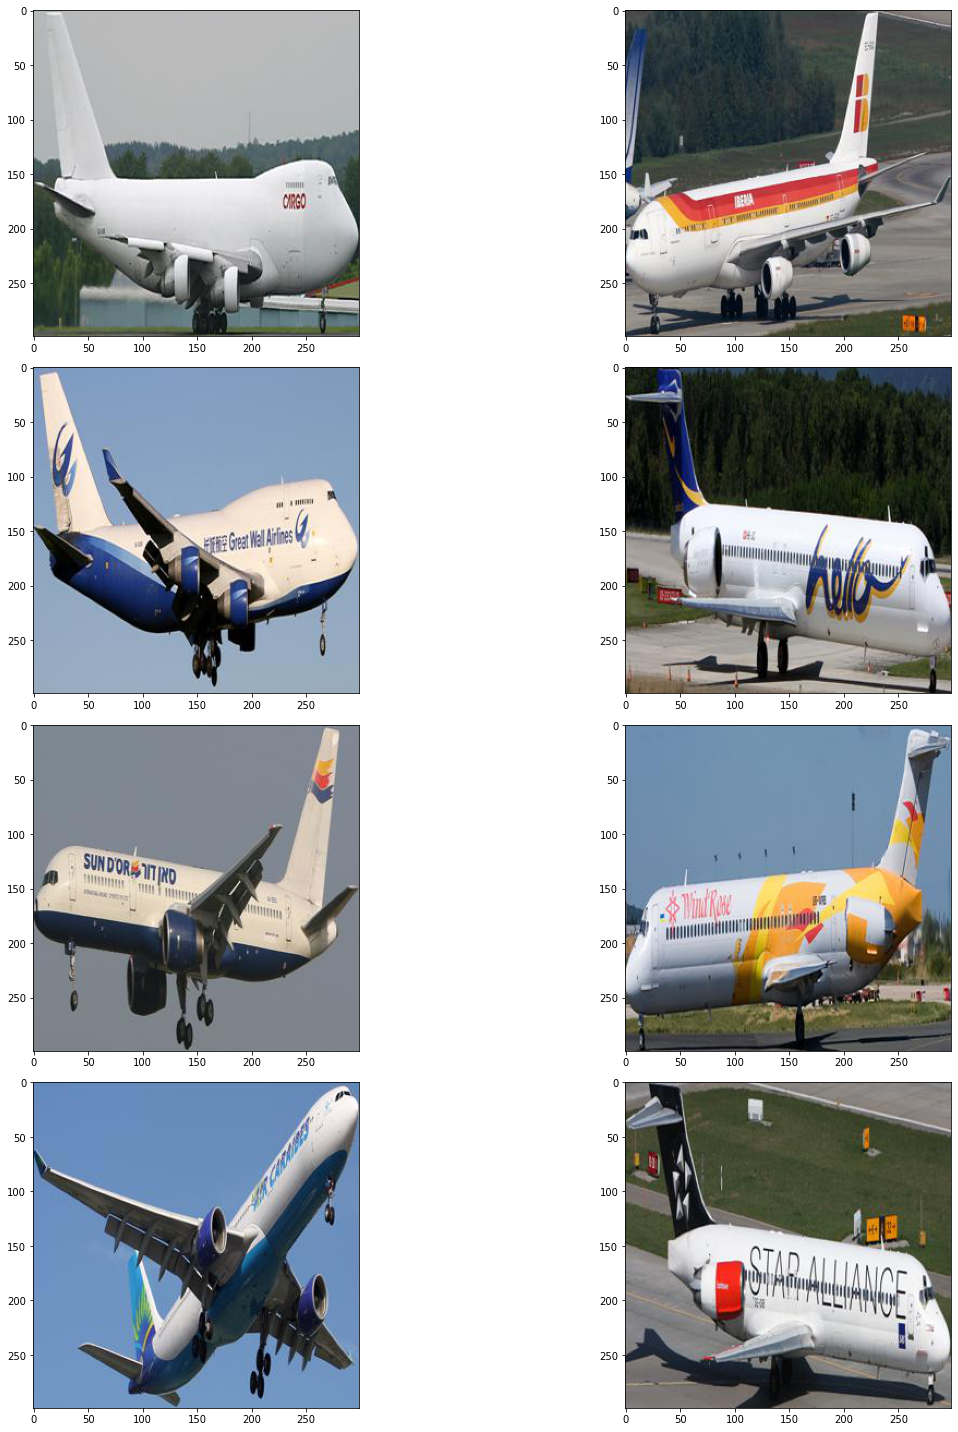

In [12]:
dir_images = ['data/variant/test/747-200/0618964.jpg',
              'data/variant/test/747-400/1922915.jpg',
              'data/variant/test/757-200/1160955.jpg',
              'data/variant/test/A330-300/1547722.jpg',
              'data/variant/test/A340-300/2061742.jpg',
              'data/variant/test/MD-90/1543498.jpg',
              'data/variant/test/MD-80/2013771.jpg',
              'data/variant/test/MD-87/2194203.jpg']

images = [Image.open(x) for x in dir_images]

f, axarr = plt.subplots(4,2, figsize=(20,20))
axarr[0,0].imshow(images[0])
axarr[1,0].imshow(images[1])
axarr[2,0].imshow(images[2])
axarr[3,0].imshow(images[3])
axarr[0,1].imshow(images[4])
axarr[1,1].imshow(images[5])
axarr[2,1].imshow(images[6])
axarr[3,1].imshow(images[7])

f.tight_layout()
f.show()

There are 3 types of aircraft that probalby are confused. It's Boeing 747 - XXX, MD - XX and Airbus A3X0. 

In [13]:
df_classification_report = pd.DataFrame(classification_report(preds_df_1['Actual'], preds_df_1['Prediction'], output_dict=True)).transpose()
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
df_classification_report

precision    recall  f1-score     support
SR-20                 1.000000  0.970588  0.985075    34.00000
Saab_2000             1.000000  0.969697  0.984615    33.00000
Metroliner            0.969697  0.941176  0.955224    34.00000
Beechcraft_1900       0.941176  0.969697  0.955224    33.00000
F-16AB                0.891892  1.000000  0.942857    33.00000
Tu-134                0.939394  0.939394  0.939394    33.00000
DR-400                0.968750  0.911765  0.939394    34.00000
BAE-125               1.000000  0.878788  0.935484    33.00000
Hawk_T1               1.000000  0.878788  0.935484    33.00000
Challenger_600        1.000000  0.878788  0.935484    33.00000
Eurofighter_Typhoon   0.891892  0.970588  0.929577    34.00000
FA-18                 0.888889  0.969697  0.927536    33.00000
Falcon_2000           0.939394  0.911765  0.925373    34.00000
Fokker_70             0.937500  0.909091  0.923077    33.00000
Dornier_328           0.966667  0.878788  0.920635    33.00000
Cessna_560            1.000000  0.852941  0.920635    34.00000
Tornado               0.864865  0.969697  0.914286    33.00000
Cessna_525            0.885714  0.939394  0.911765    33.00000
PA-28                 0.885714  0.939394  0.911765    33.00000
Global_Express        0.909091  0.909091  0.909091    33.00000
C-130                 0.935484  0.878788  0.906250    33.00000
Cessna_172            0.966667  0.852941  0.906250    34.00000
Fokker_50             1.000000  0.818182  0.900000    33.00000
CRJ-200               0.861111  0.939394  0.898551    33.00000
Il-76                 0.885714  0.911765  0.898551    34.00000
Tu-154                0.909091  0.882353  0.895522    34.00000
DHC-6                 0.965517  0.823529  0.888889    34.00000
Embraer_Legacy_600    0.964286  0.818182  0.885246    33.00000
DHC-1                 0.964286  0.818182  0.885246    33.00000
Falcon_900            0.964286  0.818182  0.885246    33.00000
Yak-42                0.857143  0.909091  0.882353    33.00000
ATR-72                0.906250  0.852941  0.878788    34.00000
DH-82                 0.794872  0.968750  0.873239    32.00000
Saab_340              0.875000  0.848485  0.861538    33.00000
An-12                 0.794872  0.939394  0.861111    33.00000
757-300               0.900000  0.818182  0.857143    33.00000
Spitfire              0.875000  0.823529  0.848485    34.00000
767-400               0.961538  0.757576  0.847458    33.00000
Model_B200            0.756098  0.939394  0.837838    33.00000
737-200               0.800000  0.875000  0.835821    32.00000
CRJ-900               0.823529  0.848485  0.835821    33.00000
Gulfstream_V          0.769231  0.909091  0.833333    33.00000
Cessna_208            0.843750  0.818182  0.830769    33.00000
A318                  0.823529  0.823529  0.823529    34.00000
Fokker_100            0.812500  0.812500  0.812500    32.00000
Gulfstream_IV         0.800000  0.823529  0.811594    34.00000
A321                  0.862069  0.757576  0.806452    33.00000
DC-9-30               0.720930  0.911765  0.805195    34.00000
ERJ_145               0.756757  0.848485  0.800000    33.00000
DC-8                  0.857143  0.750000  0.800000    32.00000
ATR-42                0.697674  0.909091  0.789474    33.00000
EMB-120               0.857143  0.727273  0.786885    33.00000
A340-500              0.909091  0.689655  0.784314    29.00000
accuracy              0.769580  0.769580  0.769580     0.76958
weighted avg          0.787969  0.769580  0.769558  3307.00000
L-1011                0.781250  0.757576  0.769231    33.00000
macro avg             0.787515  0.769163  0.769068  3307.00000
E-190                 0.634615  0.970588  0.767442    34.00000
707-320               0.800000  0.727273  0.761905    33.00000
DHC-8-100             0.627451  0.969697  0.761905    33.00000
727-200               0.710526  0.818182  0.760563    33.00000
ERJ_135               0.916667  0.647059  0.758621    34.00000
E-170                 0.952381  0.625000  0.754717  

Aircrafts with lowest accuracy reach low F1 score and precission.

<AxesSubplot:ylabel='Pair'>

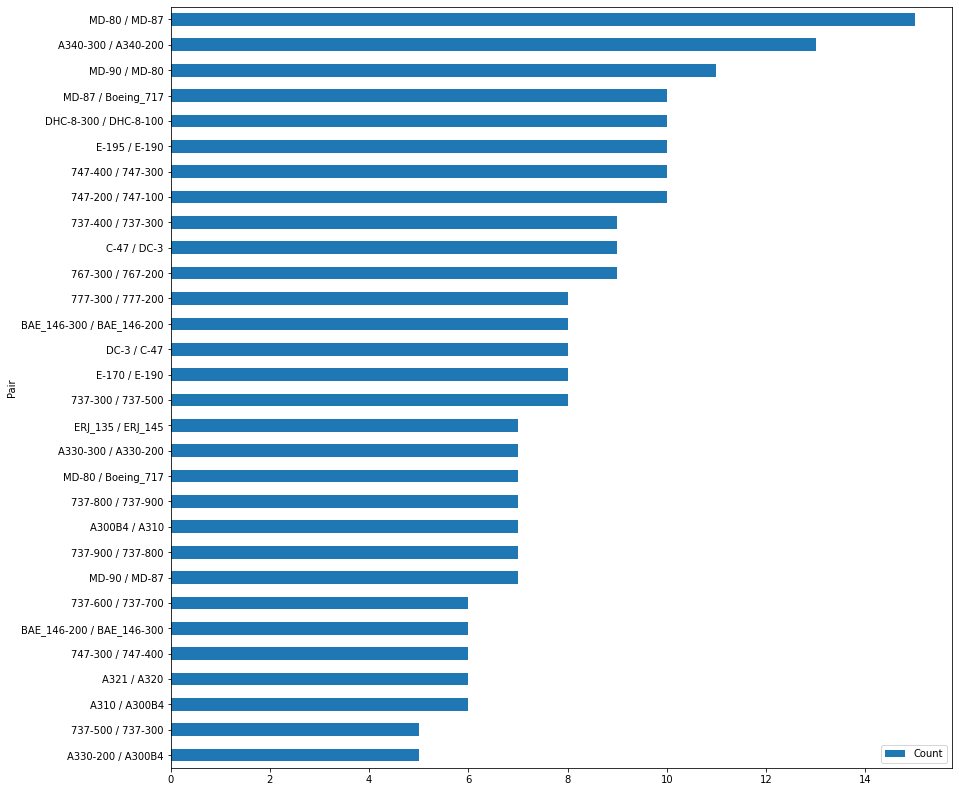

In [14]:
preds_df_1['Count'] = 1
miss_df_1 = preds_df_1[preds_df_1['Actual'] != preds_df_1['Prediction']] \
                    .groupby(['Actual', 'Prediction']) \
                    .sum().sort_values(['Count'], ascending=False) \
                    .reset_index()

miss_df_1 = miss_df_1[['Actual', 'Prediction', 'Count']]
miss_df_1['Pair'] = miss_df_1['Actual'] + ' / ' + miss_df_1['Prediction']
miss_df_1 = miss_df_1[['Pair', 'Count']].take(range(30)).set_index('Pair')
miss_df_1.sort_values(['Count']).plot.barh(figsize=(14, 14))


Mostly confused aircrafts differ from each other only by the variant, they look really similar from the outside, in most cases the only difference is the length of aircraft.

Test of classification on randomly choosen images:

##################################################
File: Cessna_560/1608084.jpg
Actual: Cessna_560
Prediction: Cessna_560


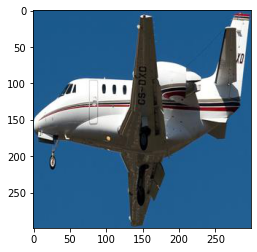

##################################################
File: 737-500/1476642.jpg
Actual: 737-500
Prediction: 737-500


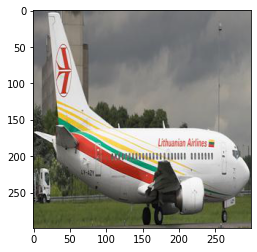

##################################################
File: 737-400/1119094.jpg
Actual: 737-400
Prediction: 737-300


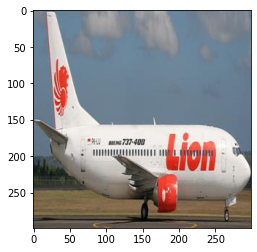

##################################################
File: Hawk_T1/2178477.jpg
Actual: Hawk_T1
Prediction: Hawk_T1


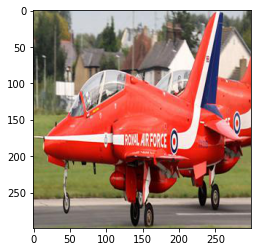

##################################################
File: Dornier_328/1092039.jpg
Actual: Dornier_328
Prediction: Dornier_328


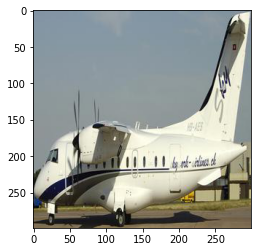

##################################################
File: Falcon_900/1206825.jpg
Actual: Falcon_900
Prediction: Falcon_900


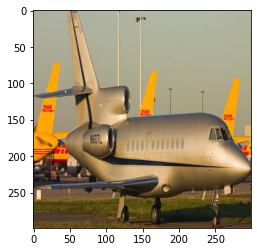

##################################################
File: A321/1231168.jpg
Actual: A321
Prediction: A321


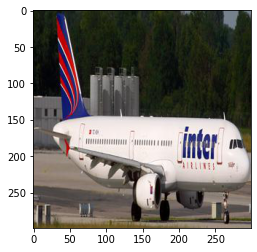

##################################################
File: 737-600/0669870.jpg
Actual: 737-600
Prediction: 737-600


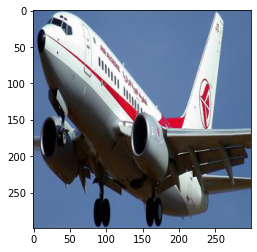

##################################################
File: Hawk_T1/1754180.jpg
Actual: Hawk_T1
Prediction: Hawk_T1


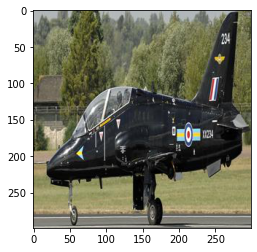

##################################################
File: Tu-154/0907404.jpg
Actual: Tu-154
Prediction: Tu-154


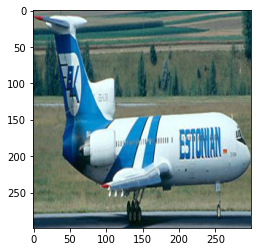

##################################################
File: A318/1393354.jpg
Actual: A318
Prediction: A318


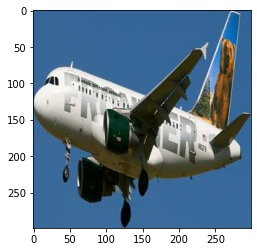

##################################################
File: Challenger_600/1223342.jpg
Actual: Challenger_600
Prediction: Challenger_600


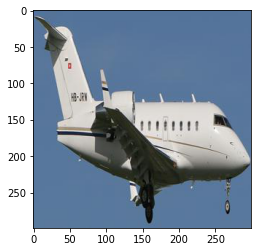

##################################################
File: DC-3/0544833.jpg
Actual: DC-3
Prediction: DC-3


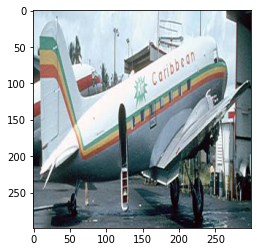

##################################################
File: 767-400/2243382.jpg
Actual: 767-400
Prediction: 767-400


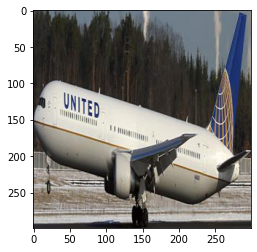

##################################################
File: MD-87/0435307.jpg
Actual: MD-87
Prediction: Boeing_717


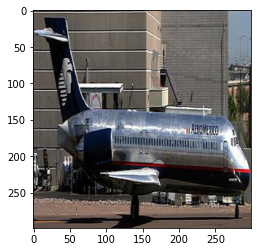

##################################################
File: 767-300/0939563.jpg
Actual: 767-300
Prediction: 767-300


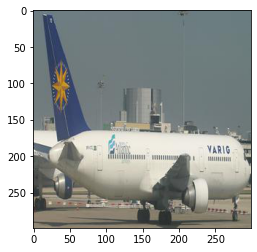

##################################################
File: 767-200/0730739.jpg
Actual: 767-200
Prediction: 757-200


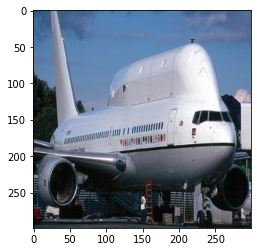

##################################################
File: Tu-134/0522967.jpg
Actual: Tu-134
Prediction: Tu-134


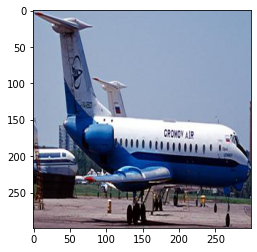

##################################################
File: Saab_340/1351194.jpg
Actual: Saab_340
Prediction: Saab_340


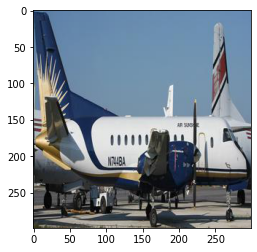

##################################################
File: Metroliner/1059772.jpg
Actual: Metroliner
Prediction: Metroliner


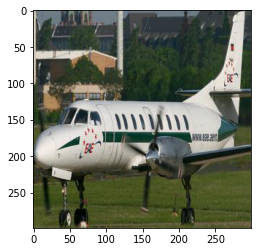

##################################################
File: DC-10/0136174.jpg
Actual: DC-10
Prediction: DC-10


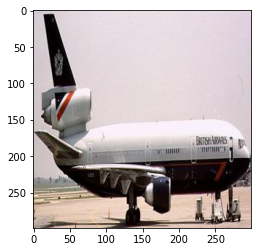

##################################################
File: 707-320/0809560.jpg
Actual: 707-320
Prediction: 707-320


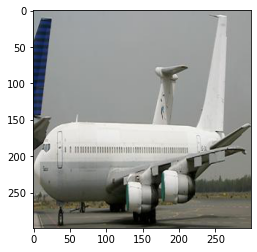

##################################################
File: Il-76/0812685.jpg
Actual: Il-76
Prediction: Il-76


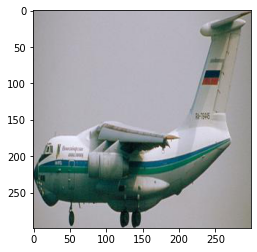

##################################################
File: DH-82/1696301.jpg
Actual: DH-82
Prediction: DH-82


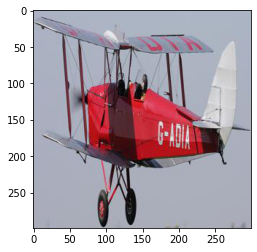

##################################################
File: SR-20/2151715.jpg
Actual: SR-20
Prediction: SR-20


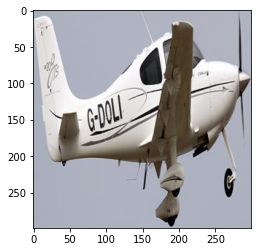

##################################################
File: Spitfire/1384345.jpg
Actual: Spitfire
Prediction: F-16AB


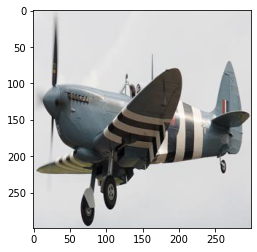

##################################################
File: Metroliner/0074462.jpg
Actual: Metroliner
Prediction: Metroliner


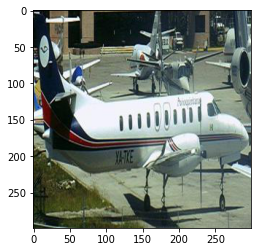

##################################################
File: A380/1921950.jpg
Actual: A380
Prediction: A380


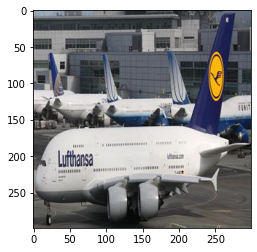

##################################################
File: DR-400/1329269.jpg
Actual: DR-400
Prediction: DR-400


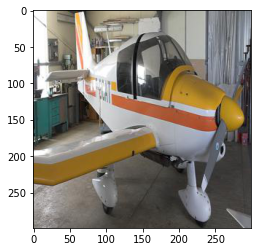

##################################################
File: C-130/0736232.jpg
Actual: C-130
Prediction: C-130


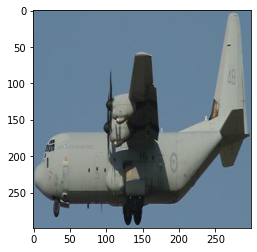

In [26]:
number_of_test_images = len(test_dataset.filenames)
random_numbers = [random.randint(0,number_of_test_images-1) for x in range(0,30)]
for index in random_numbers:
    print('#'*50)
    file = preds_df_1.iloc[index]['File']
    print('File:',file)
    print('Actual:',preds_df_1.iloc[index]['Actual'])
    print('Prediction:',preds_df_1.iloc[index]['Prediction'])
    img = Image.open('data/variant/test/'+file)
    plt.imshow(img)
    plt.show()